# Problem 3: A More Complicated MPT Model (10 points)


## Part 1:

Write down the model equations for the MPT model depicted in Figure 1 in the paper (avaliable
on LMS):

### Equations:

![MPT model depicted](mpt_model_image.jpg "Title")


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [44]:
# Define equations and categorical probabilities

# Set global set
global_rng = np.random.default_rng(42)

# Fix true parameters
true_params = {
    'a': 0.75,
    'b': 0.8, 
    'c': 0.7,
    'd': 0.6,
    'e': 0.5,
    'f': 0.4,
    'g': 0.3,
    'h': 0.2,
}
a = 0.75
b = 0.8
c = 0.7
d = 0.6
e = 0.5
f = 0.4
g = 0.3
h = 0.2


# Fix true probabilities
true_probs = {    
    'NR': (1 - a),                                                                          # no response
    'AN': a * (1 - b) * (1 - f) * (1 - h) + a * b * (1 - c) * (1 - f) * (1 - h) ,           # abtruse neologism
    'U': a * (1 - b) * (1 - f) * h + a * (1 - b) * f + a * b * (1 - c) * ( 1- f) * h,                         # unrelated
    'S': a * b * (1 - c) * f,                                                                 # semantic
    'N': a * b * c * (1 - d) * (1 - f) * (1 - g) + a * b * c * d * (1 - e) * (1 - f) * (1 - g) + a * b * c * d * e * (1 - f) * (1 - g),       # neologism
    'F': a * b * c * (1 - d) * f + a * b * c * (1 - d) * (1 - f) * g + a * b * c * d * (1 - e) * (1 - f) * g + a * b * c * d * e * (1 - f) * g,   # formal
    'M': a * b * c * d * (1 - e) * f,                                                                   # mixed
    'C': a * b * c * d * e * f                                                                        # correct
}

# Simulate Data
num_trials = 100
data = global_rng.multinomial(n=num_trials, pvals=list(true_probs.values()))

pd.DataFrame(data[None, :], columns=true_probs.keys(), index=['frequencies'])

,NR,AN,U,S,N,F,M,C
frequencies,28,15,13,8,11,10,6,9


In [27]:
data

array([28, 15, 13,  8, 11, 10,  6,  9])

## Part 2:

Then, write a Stan program for the MPT model featuring the following five blocks: data – for
passing the hypothetical categorical data; parameters – for defining the latent model parameters;
transformed parameters – for transforming latent model parameters into probabilities; model –
for formulating the Bayesian joint model; generated quantities – for sampling new frequency
data given the posterior draws (generative performance).

In [28]:
mpt_model_code = """
data {
  int<lower=1> N;
  int<lower=1> K;
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> a;
  real<lower=0, upper=1> b;
  real<lower=0, upper=1> c;
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> e;
  real<lower=0, upper=1> f;
  real<lower=0, upper=1> g;
  real<lower=0, upper=1> h;
}

transformed parameters {
  simplex[K] theta;
  // Pr_NoResponse
  theta[1] = (1 - a);          // Pr_NoResponse

  // Pr_AbtruseNeologism
  theta[2] = a * (1 - b) * (1 - f) * (1 - h) + 
    a * b * (1 - c) * (1 - f) * (1 - h);   // Pr_AbtruseNeologism

  // unrelated
  theta[3] = a * (1 - b) * (1 - f) * h + 
    a * (1 - b) * f + 
    a * b * (1 - c) * ( 1- f) * h;                    

  // semantic
  theta[4] = a * b * (1 - c) * f;

  // neologism
  theta[5] = a * b * c * (1 - d) * (1 - f) * (1 - g) + 
    a * b * c * d * (1 - e) * (1 - f) * (1 - g) + 
    a * b * c * d * e * (1 - f) * (1 - g); 

  // formal
  theta[6] = a * b * c * (1 - d) * f + 
    a * b * c * (1 - d) * (1 - f) * g + 
    a * b * c * d * (1 - e) * (1 - f) * g + 
    a * b * c * d * e * (1 - f) * g;

  // mixed
  theta[7] = a * b * c * d * (1 - e) * f;

  // correct
  theta[8] = a * b * c * d * e * f;

}

model {
  target += beta_lpdf(a | 1, 1);
  target += beta_lpdf(b | 1, 1);
  target += beta_lpdf(c | 1, 1);
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(e | 1, 1);
  target += beta_lpdf(f | 1, 1);
  target += beta_lpdf(g | 1, 1);
  target += beta_lpdf(h | 1, 1);
  target += multinomial_lpmf(freqs | theta);
}

generated quantities{
  array[K] int pred_freqs;
  pred_freqs = multinomial_rng(theta, N);
}
"""

## Bonus (6 points): Simulate & Inspect 

Instructions: Simulate a data set according to the forward model and inspect parameter recovery.

In [29]:
# Prepare data
stan_dict = {
    'freqs': data,
    'N': num_trials,
    'K': data.shape[0]
}


# Compile model
posterior = stan.build(mpt_model_code, data=stan_dict, random_seed=42)


# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.000145 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000116 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000105 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000107 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.07 seconds.
  Adjust your expectations accordingly!


In [30]:
summary = az.summary(fit)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.716,0.044,0.635,0.799,0.000,0.000,9115.0,6779.0,1.0
b,0.738,0.084,0.577,0.901,0.001,0.001,3994.0,2472.0,1.0
c,0.669,0.083,0.518,0.825,0.001,0.001,4692.0,5321.0,1.0
d,0.781,0.134,0.556,1.000,0.002,0.001,3813.0,3084.0,1.0
e,0.589,0.116,0.379,0.803,0.001,0.001,8353.0,6889.0,1.0
f,0.497,0.091,0.323,0.659,0.002,0.001,3543.0,5314.0,1.0
g,0.357,0.150,0.065,0.632,0.002,0.002,3819.0,2553.0,1.0
h,0.226,0.141,0.000,0.464,0.002,0.002,3703.0,3517.0,1.0
theta[0],0.284,0.044,0.201,0.365,0.000,0.000,9115.0,6779.0,1.0
theta[1],0.140,0.032,0.082,0.198,0.000,0.000,12240.0,8327.0,1.0


/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (72), generating only 20 plots
  warnings.warn(


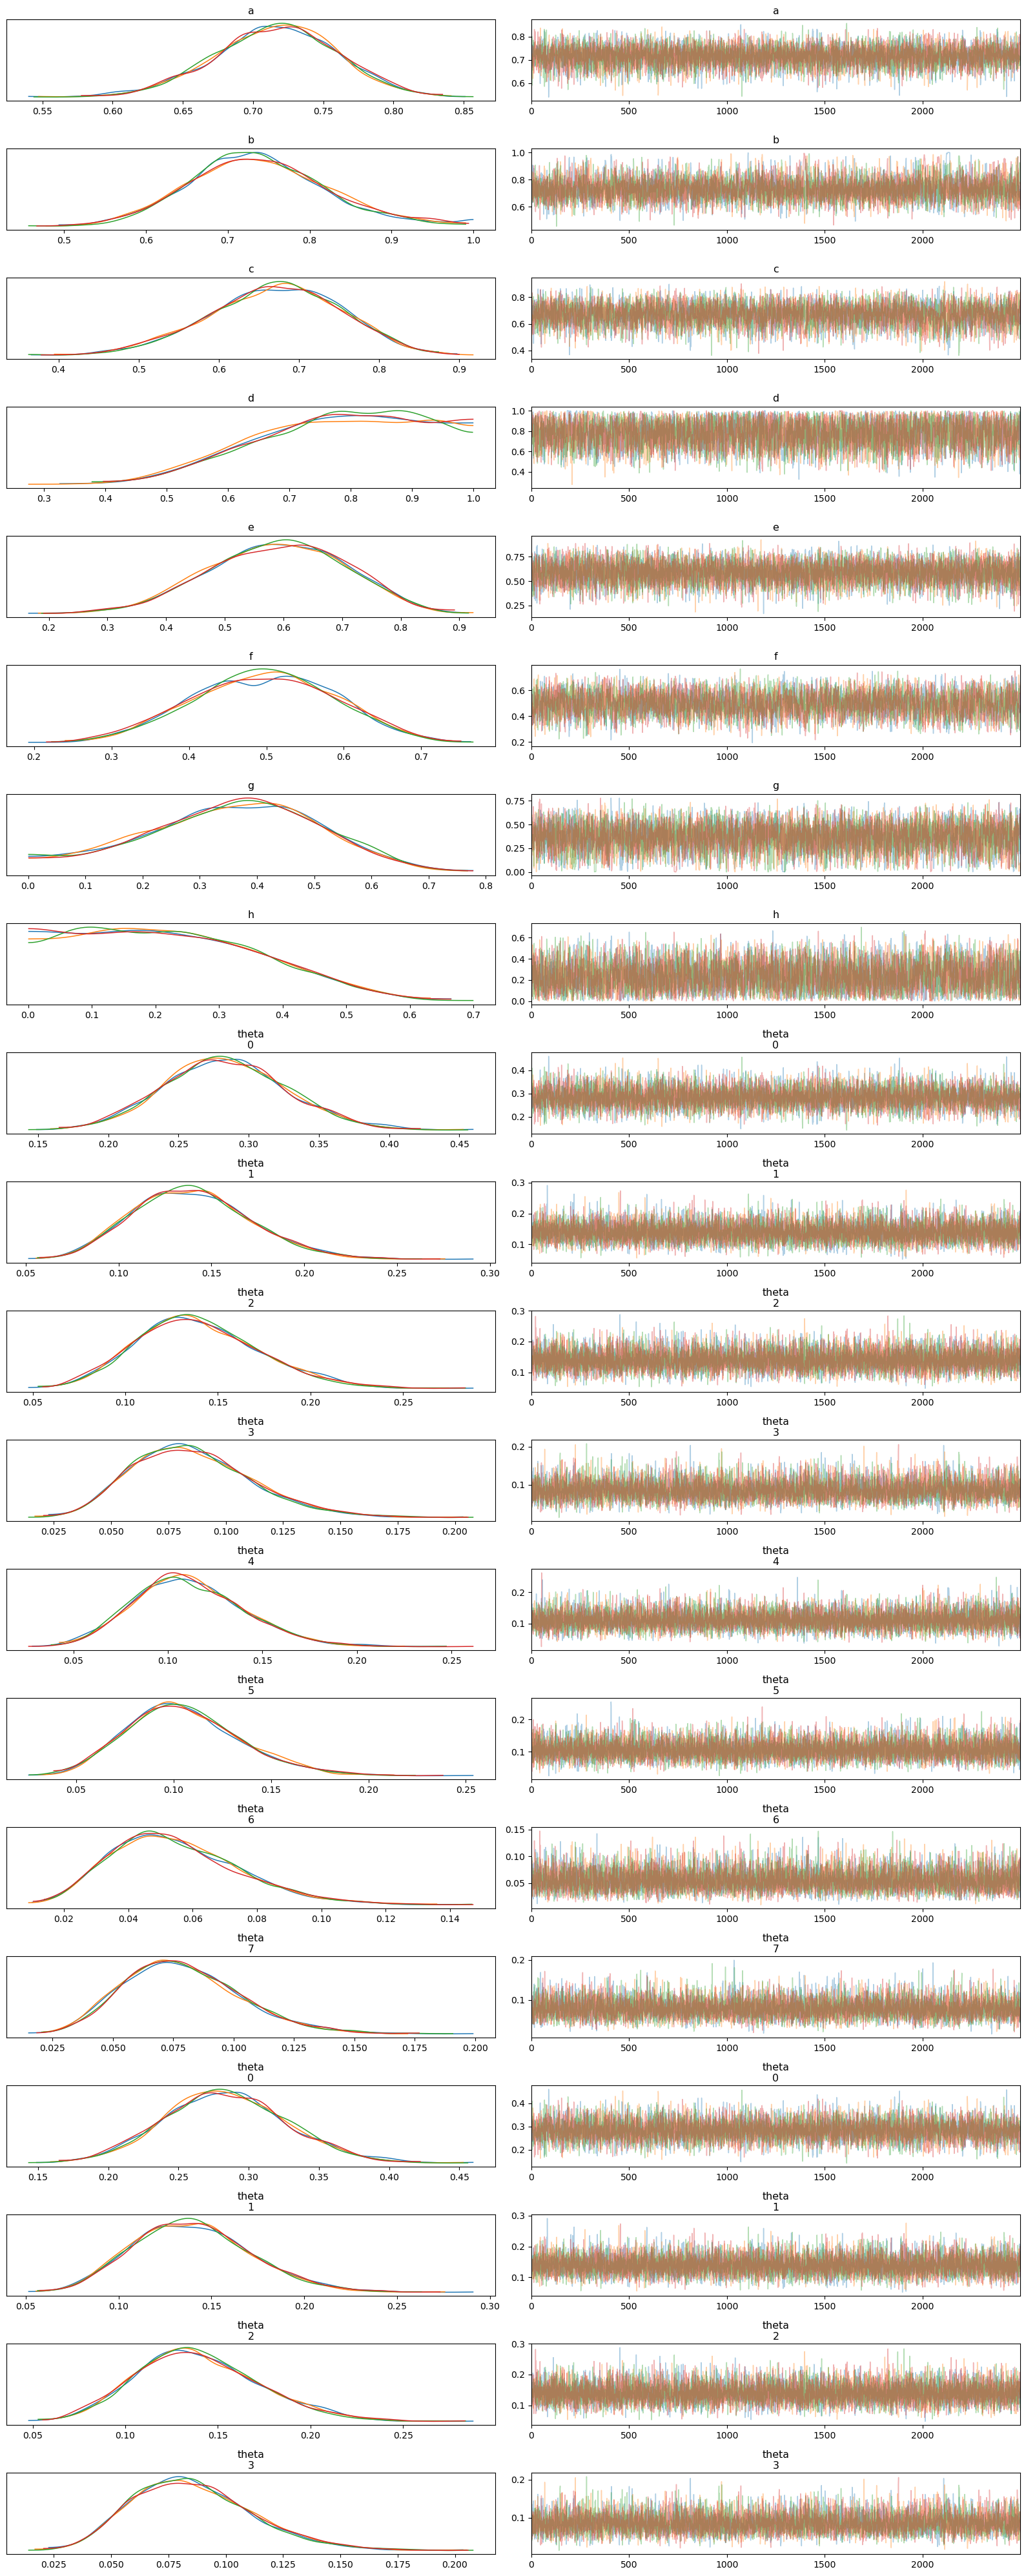

In [45]:
ax = az.plot_trace(fit, var_names=fit.param_names, filter_vars='like', compact=False, legend=False, figsize=(16, 40))

plt.tight_layout()

### Parameters Recovery Discussion:

Observing the summary statisics, it seems that the recovery of the original perameters was strong - this is proven by several factors. For each perameter, we can clearly identify the the r_hat is 1 (which is when this value is closer to one, the more we can say that the chains reached convergence). We can also tell that for the mean of each parameter they are very close to the true/ simulated baseline data; for example a was set to be .75, and the mean of a from the simulated summary was .716 - this pattern of being very close persists for all the other perameters. These factors, and more (such as the converence seen visually from the graphs above, etc...) indicate strong perameter recovery. It can be posulated that given more data, it will get stronger.